# Topic Modeling

## What is a topic model?

Topic models, like [Latent Dirichlet Allocation (LDA)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), have traditionally been used to decompose a corpus of text into topics - or themes - composed of words that often appear together in documents. Documents, in turn, are modeled as a mixture of topics based on the words they contain. 

MIRA extends these ideas to single-cell genomics data, where topics are groups of genes that are co-expressed or *cis*-regulatory elements that are co-accessible, and cells are a mixture of these regulatory modules. The topics can be used for enrichment and pathway analysis, while the cells' topic mixtures can be used to embed the cells in an informative, interpretable latent space.

Topic modeling of batched single-cell data is challenging because these models cannot typically distinguish between biological and technical effects of the assay. CODAL (COvariate Disentangling Augmented Loss) uses a novel mutual information regularization technique to explicitly disentangle these two sources of variation.


## Tuning and training

In this tutorial, we will cover tuning and training MIRA topic models (which now run the CODAL algorithm underneath) to find the best hyperparameters for a given dataset. Single-cell datasets vary widely in terms of quality and complexity, and as such, no set of hyperparameters will ensure an optimal model in all cases. The most important parameter to optimize for a given dataset is the number of topics captured by the model, which represents units of covarying genes or *cis*-regulatory regions. The number of topics determines the quality of the embedding manifold and veracity of the topics' functional enrichments, so we recommend rigourous tuning to provide an accurate and informative analysis. 

MIRA uses a memory efficient streaming minibatch stochastic gradient descent algorithm for parameter inference. This enables parallelized and fast Bayesian optimization of key hyperparameters of the model. Hyperparameters tuning proceeds in three stages:

1. Feature selection and data cleaning
2. Model instantiation
3. Bayesian optimization

Let's start by importing some packages:

In [1]:
import mira

import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

And we'll load some data. To make the tutorial quick, I've imported a synthetic single-cell dataset used as part of benchmarking CODAL's ability to disentangle technical and biological effeccts. This synthetic dataset contains two batches with 2000 cells each. One batch is "WT", and the other is "KO", or perturbed. Importantly, these batches have different cell-state distributions.

In [2]:
mira.datasets.CodalFrankencellTutorial()

ko = anndata.read_h5ad('mira-datasets/CODAL_tutorial/perturbation.h5ad')
wt = anndata.read_h5ad('mira-datasets/CODAL_tutorial/wild-type.h5ad')

data = anndata.concat({'ko' : ko, 'wt' : wt}, label='batch', index_unique=':') # combine into one dataframe

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/CODAL_tutorial
		* perturbation.h5ad
		* wild-type.h5ad


## Step 1: Feature selection

**All of MIRA's models have the same API for instantiating, tuning, and training, regardless of the data mode.** This tutorial covers tuning of an expression topic model.

First, we must perform feature selection to find highly variable genes. We recommend finding highly variable genes over the concatenation of all batches you intend to merge, which is easy to accomplish using [Scanpy](https://scanpy.readthedocs.io/en/stable/tutorials.html). First, filter very rare genes, and freeze the raw counts:

In [3]:
sc.pp.filter_genes(data, min_cells=15)
data.raw = data

Normalize the read depths of each cell, then logarithmize the data:

In [4]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

And calculate highly variable genes. This set of genes will be our "exogenous" genes, or those we include in our statistical model of the data. As a rule of thumb, using the top 2500-5000 highly variable genes works well for describing the data manifold and finding interesting enrichments in topics.

In [5]:
sc.pp.highly_variable_genes(data, min_disp = 0.5)

Finally, restore the raw counts to the `counts` layer.

In [6]:
data.layers['counts'] = data.raw.to_adata().X.copy()

## Step 2: Model instantiation

Next, we will instantiate an expression topic model. The hyperparameters will be tuned in the following stage, so all we have to worry about is telling the topic model how to access some information in our `AnnData` object. 

Particularly, and at a minimum, we must tell the model

* `feature_type`: what type of features we are working with (either "expression" or "accessibility")
* `exogenous_key`: which `.var` key to find our highly variable genes
* `counts_layer`: which layer to get the raw counts from.
* `categorical_covariates`, `continuous_covariates`: Technical variables influencing the generative process of the data. For example, a categorical technical factor may be the cells' batch of origin, as shown here. A continous technical factor might be % of mitchondrial reads. For unbatched data, ignore these parameters.

In [7]:
model = mira.topics.TopicModel(
    data.n_obs, data.n_vars, # helps MIRA choose reasonable values for some hyperparameters which are not tuned.
    feature_type = 'expression',
    exogenous_key='highly_variable',
    counts_layer='counts',
    categorical_covariates='batch'
)

Next, we have to set minimum and maximum bounds on the learning rate which works for the model. The learning rate will be annealed during training between these values to ensure the best fit. Run the learning rate range test below to collect data on which learning rates work given the model setup:

In [8]:
model.get_learning_rate_bounds(data)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable


Gathering dataset statistics:   0%|          | 0/4000 [00:00<?, ?it/s]

Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (0.001102177009946407, 0.1901675701910509)


(0.001102177009946407, 0.1901675701910509)

Now, use the `set_learning_rates` function to bound the part of the loss curve which contains the steepest decrease.

**If you push the upper bound too high, the model is likely to experience gradient overflows. The upper bound works best *at* or *before* the point where the slope starts to level off.**

<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

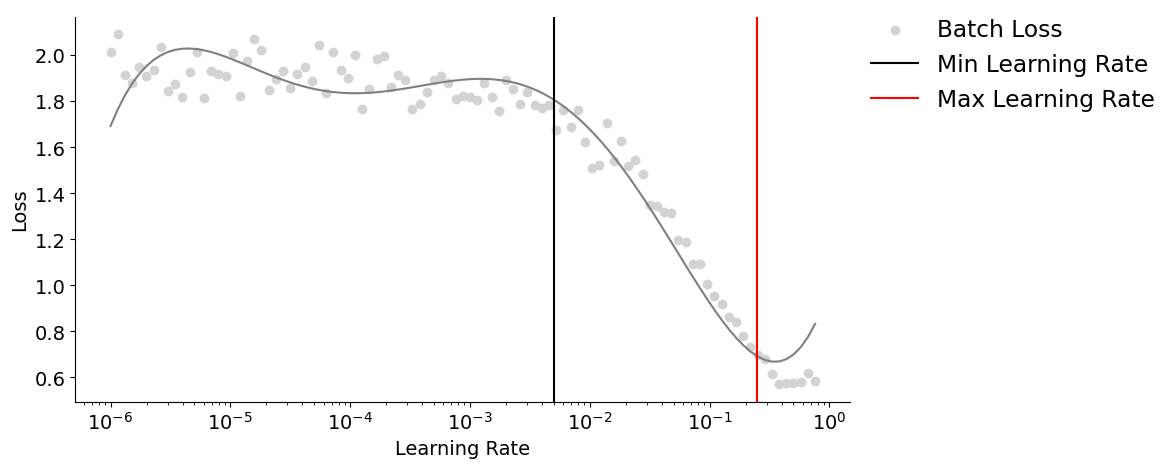

In [9]:
model.set_learning_rates(5e-3, 0.25)
model.plot_learning_rate_bounds(figsize=(10,5))

## Step 3: Bayesian Optimization

To tune the number of topics used to describe the dataset, we'll use a `SpeedyTuner` object. This class takes as arguments:

* The model
* `save_name`, which allows us to resume or reload a training session. This is a unique filepath at which the tuner will save its progress
* `n_jobs`, the number of parallel processes to run. 
* the `min_topics` and `max_topics`, bounds on the number of topics which may be contained in a dataset.

**In single-core mode, tuning is deterministic** (if nothing changes/no trials drop due to environmental reasons). Multicore mode is also deterministic, barring race conditions. If trials finish out of order due to environmental differences, the tuning will not reproduce *exactly*.

### Notes on `n_jobs`

During the fitting stage, MIRA caches the dataset to disk, then streams minibatches into memory for gradient descent steps. This means each training instance has a very small memory footprint which is irrespective of the size of the dataset. Therefore, one can conservatively allocate one process per ~1 GB of available memory. 

However, parallelization requires that the tuner has a backend database to coordinate all of those processes. By default, MIRA uses an SQLite table which requires no setup, but this only works up to 5 concurrent jobs (`n_jobs=5`). For more processes, you will have to use the REDIS backend database. To do this, start a Redis server running in the background - this can be configured however you like. Then, pass the argment `storage = mira.topics.Redis()` to the tuner object.

**In single-core mode, tuning is deterministic** (if nothing changes/no trials drop due to environmental reasons). Multicore mode is also deterministic, barring race conditions. If trials finish out of order due to environmental differences, the tuning will not reproduce *exactly*.

## Notes on `min_topics`, `max_topics`

Setting reasonable bounds on the range of topics one might encounter can help speed up convergence of the tuner. For example, typical PBMC datasets contain 10-15 topics, bone marrow differentiation contains 20-30 topics, and the embryonic differentiation dataset analyzed in our manuscript contained 70-80 topics. One option is to get a quick estimate of how many cell states are in your dataset via PCA or clustering, then provide bounds which overlap this estimate. Alternatively, you can provide very permissive bounds, like 5-55 topics.

In [10]:
tuner = mira.topics.SpeedyTuner(
        model = model,
        n_jobs=5,
        save_name = 'tutorial/0',
        min_topics = 3, 
        max_topics = 20,
)

After instantiating the tuner, call the `fit` function and provide your dataset:

In [11]:
tuner.fit(data)

Trials finished: 43 | Best trial: 17 | Best score: 7.2553e+02
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/tutorial/0
#Topics | #Trials 

      3 | ■ ■ 
      4 | ■ 
      6 | ■ ■ ■ ■ ■ 
      7 | ■ ■ ■ ■ ■ ■ ■ ■ 
      8 | ■ ■ ■ 
      9 | ■ 
     10 | ■ ■ 
     12 | ■ 
     13 | ■ 
     16 | ■ ■ 
     17 | ■ 
     18 | ■ ■ 
     19 | ■ ■ 
     20 | ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   |   | pruned at step: 8            | {'decoder_dropout': 0.1120, 'num_topics': 16}
 #1   |   | pruned at step: 16           | {'decoder_dropout': 0.1397, 'num_topics': 12}
 #2   |   | pruned at step: 8            | {'decoder_dropout': 0.0583, 'num_topics': 19}
 #3   | ● | completed, score: 7.2636e+02 | {'decoder_dropout': 0.1389, 'num_topics': 6}
 #4   |   | pruned at step: 8            | {'decoder_dropout': 0.0515, 'num_topics': 16}
 #5   |   | pruned at step: 8            | {'decoder_dropout': 0.0794, 'num_topics': 17}
 #6   |

After running some optimization trials with random hyperparamters, the tuner will hone in on the optimal number of topics that best represents the dataset. A good indicator of convergence is that the histogram on the dashboard shows the model is preferentially choosing topic numbers over some limited range.

After tuning, you can assess the tuner fit by plotting the intermediate loss values recorded during each trial with `plot_intermediate_values`. Here, we just want to ensure that model training is converging to a stable solution.

[(700.0, 770.0)]

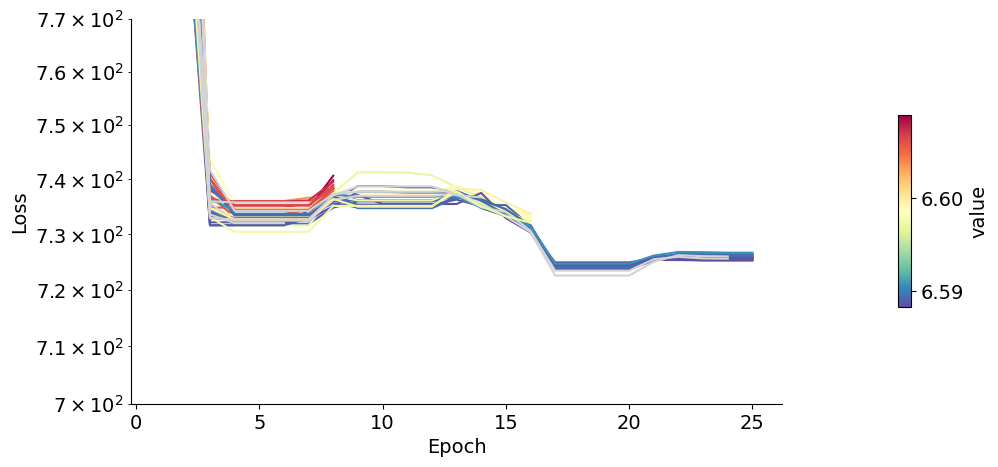

In [12]:
ax = tuner.plot_intermediate_values(palette='Spectral_r',
                                   log_hue=True, figsize=(10,5))
ax.set(ylim = (7e2, 7.7e2))

Next, we can check that the losses achieved by various models are convex with respect to the number of topics. This check ensures that a reasonable number of topics was chosen for the model and that the tuner converged on that esimate:

<AxesSubplot:xlabel='Num_topics', ylabel='Elbo'>

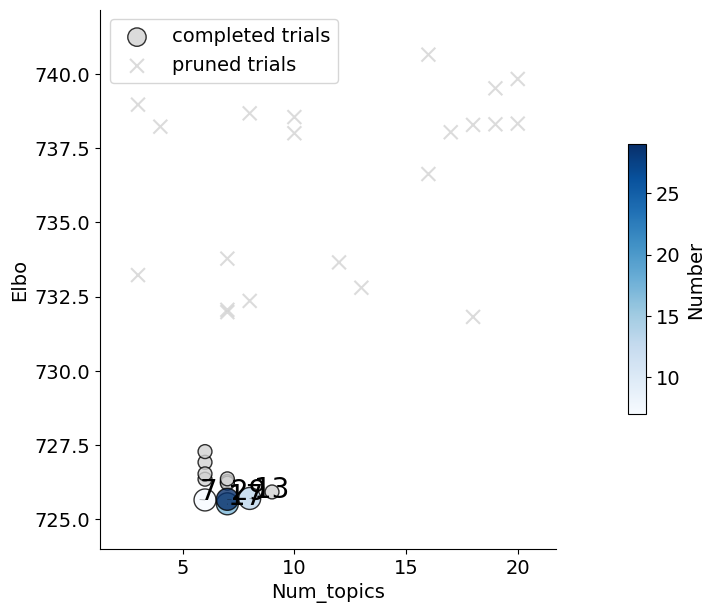

In [13]:
tuner.plot_pareto_front(include_pruned_trials=True, label_pareto_front=True)

One can also check that the tuner's solutions generally got better over time (there will always be some exploration which may not yield better scores):

<AxesSubplot:xlabel='Number', ylabel='Value'>

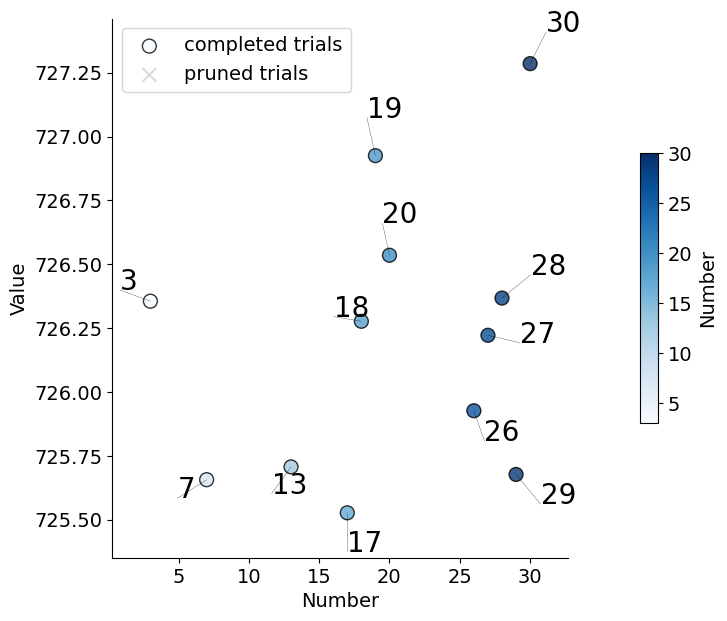

In [14]:
tuner.plot_pareto_front(include_pruned_trials=False,
                        x = 'number', 
                        y = 'value',
                        hue = 'number', 
                        label_pareto_front=False)

Finally, you can access the model which is the best fit for your dataset using the `fetch_best_weights` command. The weights and hyperparamter choices for this model were saved during the tuning phase, so it is ready to be used for your analysis.

In [15]:
model = tuner.fetch_best_weights()

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


## Step 4: Analysis

The first thing you may want to do with your model is embed the cells in some low-dimensional space for visualization. The `predict` function infers the topic composition of each cell in the dataset, then `get_umap_features` transforms the topic compositions to euclidean space for nearest-neighbors analysis. From there, we can used the `scanpy` workflow to generate a 2-dimensional UMAP visualization of the dataset.

For more on analyzing embeddings, projections, and topics, please see the [MIRA tutorial](https://mira-multiome.readthedocs.io/en/latest/notebooks/tutorial_joint_representation.html). The APIs are unchanged, except those outlined in the **Model Persistence** section.

In [16]:
model.predict(data)

model.get_umap_features(data, box_cox=0.5)

# scanpy workflow # 
sc.pp.neighbors(data, use_rep = 'X_umap_features', metric = 'manhattan')
sc.tl.umap(data, min_dist=0.1, negative_sample_rate=0.05)

Predicting latent vars:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


*Voilà*, potting this dataset, we can see that the batches have been successfully merged! We also see that CODAL was able to determine that the KO batch (red) contained a new cell type unseen in the control batch (black). As we show in our manuscript, correcting for technical effects in this situation is quite challenging for other methods.

/Users/alynch/opt/miniconda3/envs/codal/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/alynch/opt/miniconda3/envs/codal/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
... storing 'edge' as categorical


Text(0.5, 1.0, 'UMAP projection')

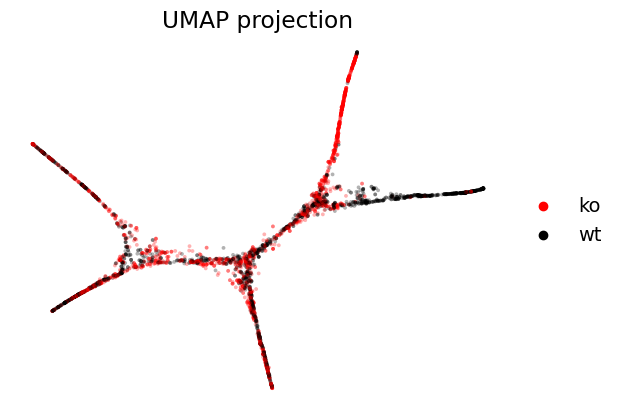

In [17]:
ax = sc.pl.umap(data[np.random.choice(len(data), len(data))], frameon=False, color = 'batch',
               title = '', palette=['red','black'],
               alpha = 0.3, show=False)
ax.set_title('UMAP projection')

For more on analyzing topics, please see the [tutorial](https://mira-multiome.readthedocs.io/en/latest/notebooks/tutorial_topic_analysis.html) on the MIRA website.

## Tuning persistence

Tuning results/trials/parameters are saved to a SQLite database in the working directory called "mira-tuning.db" (which can be changed through the `storage` parameter of the tuning object). Specific optimization runs are saved to their own tables, named by the `save_name` parameter. Thus, to resume tuning after an interuption, one must simply instantiate a tuning object with the same `storage` and `save_name` parameters as the previous process. The new object will reference the saved results and pick up where the last process left off. This means if you start a new tuning process by running a script - which is then interrupted - rerunning that script will resume the original training session.

## Model persistence

Once you have a trained topic model, it would be a good idea to save it to disk so you can access it again later. We recommend the `.pth` extension, which is the extension Pytorch uses when saving weights.

In [18]:
model.save('mira-datasets/tutorial_model.pth')

That model can be reloaded using:

In [19]:
model = mira.topic_model.load_model('mira-datasets/tutorial_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Please note, this API was changed from previous MIRA versions. 